# **Deteksi dan Pengenalan Wajah pada KTP**

## **Kelompok 2**

| Absen | Nama Anggota           | NIM <br>   |
| ----- | ---------------------- | ---------- |
| 03    | Adinda Wahyu L.        | 2141720096 |
| 04    | Alfan Olivan           | 2141720078 |
| 15    | Lukas Valentino        | 2141720032 |
| 17    | M. Driya Ananta        | 2141720224 |
| 28    | Wiradarma Nurmagika B. | 2141720184 |

### **Hasil**

#### 1. Import Library

In [ ]:
# import the necessary packages
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils
from google.colab.patches import cv2_imshow
from skimage import exposure
from keras.models import load_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### 2. Define a function

In [ ]:
def preprocess_image(image_path):
    """
    Preprocess the input image by converting it to grayscale, applying Gaussian blur, and finding edges.

    Parameters:
    - image_path: Input image file path.

    Returns:
    - edged: Processed image with edges.
    - original: Original input image.
    """

    # Read the input image
    original = cv2.imread(image_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Find edges using Canny edge detection
    edged = cv2.Canny(blurred, 75, 200)

    return edged, original

In [ ]:
def find_contours(edged_image, num_contours=5):
    """
    Find contours in the edged image and keep only the largest ones.

    Parameters:
    - edged_image: Edged image (numpy array).
    - num_contours: Number of largest contours to keep.

    Returns:
    - largest_contours: List of largest contours.
    """

    # Find contours in the edged image
    contours = cv2.findContours(edged_image.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)

    # Sort contours by area in descending order
    largest_contours = sorted(contours, key=cv2.contourArea, reverse=True)[:num_contours]

    return largest_contours

In [ ]:
def crop_image_with_max_contours(original_image, contours):
    """
    Crop the original image based on the maximum contours.

    Parameters:
    - original_image: Original input image (numpy array).
    - contours: List of contours.

    Returns:
    - cropped_image: Cropped image.
    """

    # Create a mask for the contours
    mask = np.zeros_like(original_image)

    # Draw the contours on the mask
    cv2.drawContours(mask, contours, -1, (255, 255, 255), thickness=cv2.FILLED)

    # Bitwise AND operation to get the region of interest (ROI)
    masked_image = cv2.bitwise_and(original_image, mask)

    # Find the bounding box of the contours
    x, y, w, h = cv2.boundingRect(np.vstack(contours))

    # Crop the original image based on the bounding box
    cropped_image = original_image[y:y+h, x:x+w]

    return cropped_image

In [ ]:
def detect_and_crop_faces(img, scaleFactor=1.2, minNeighbors=5):
    # Convert into grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Load the cascade
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt2.xml')

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor, minNeighbors)

    # Draw rectangle around the first detected face and crop it
    if len(faces) > 0:
        x, y, w, h = faces[0]
        # Increase rectangle radius
        padding = 20
        x -= padding
        y -= padding
        w += 2 * padding
        h += 2 * padding

        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
        cropped_face = img[y:y+h, x:x+w]
    else:
        # No face detected
        cropped_face = None

    # Return the original image with rectangles drawn around the first detected face and the cropped face
    return img, cropped_face

In [ ]:
#function to order points to proper rectangle
def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype="float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect


#function to transform image to four points
def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)

    # # multiply the rectangle by the original ratio
    # rect *= ratio

    (tl, tr, br, bl) = rect

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped


#function to find two largest countours which ones are may be
#  full image and our rectangle edged object
def findLargestCountours(cntList, cntWidths):
    newCntList = []
    newCntWidths = []

    #finding 1st largest rectangle
    first_largest_cnt_pos = cntWidths.index(max(cntWidths))

    # adding it in new
    newCntList.append(cntList[first_largest_cnt_pos])
    newCntWidths.append(cntWidths[first_largest_cnt_pos])

    #removing it from old
    cntList.pop(first_largest_cnt_pos)
    cntWidths.pop(first_largest_cnt_pos)

    #finding second largest rectangle
    seccond_largest_cnt_pos = cntWidths.index(max(cntWidths))

    # adding it in new
    newCntList.append(cntList[seccond_largest_cnt_pos])
    newCntWidths.append(cntWidths[seccond_largest_cnt_pos])

    #removing it from old
    cntList.pop(seccond_largest_cnt_pos)
    cntWidths.pop(seccond_largest_cnt_pos)

    print('Old Screen Dimentions filtered', cntWidths)
    print('Screen Dimentions filtered', newCntWidths)
    return newCntList, newCntWidths


#driver function which identifieng 4 corners and doing four point transformation
def convert_object(image, screen_size = None, isDebug = False):

    # image = imutils.resize(image, height=300)
    # ratio = image.shape[0] / 300.0


    # convert the image to grayscale, blur it, and find edges
    # in the image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bilateralFilter(gray, 11, 17, 17)  # 11  //TODO 11 FRO OFFLINE MAY NEED TO TUNE TO 5 FOR ONLINE

    gray = cv2.medianBlur(gray, 5)
    edged = cv2.Canny(gray, 30, 400)

    if isDebug  : cv2_imshow(edged)
    # find contours in the edged image, keep only the largest
    # ones, and initialize our screen contour

    countours, hierarcy = cv2.findContours(edged, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

    if isDebug : print('length of countours ', len(countours))

    imageCopy = image.copy()
    if isDebug : cv2_imshow(cv2.drawContours(imageCopy, countours, -1, (0, 255, 0), 1))


    # approximate the contour
    cnts = sorted(countours, key=cv2.contourArea, reverse=True)
    screenCntList = []
    scrWidths = []
    for cnt in cnts:
        peri = cv2.arcLength(cnt, True)  # cnts[1] always rectangle O.o
        approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
        screenCnt = approx
        # print(len(approx))

        if (len(screenCnt) == 4):

            (X, Y, W, H) = cv2.boundingRect(cnt)
            # print('X Y W H', (X, Y, W, H))
            screenCntList.append(screenCnt)
            scrWidths.append(W)

        # else:
        #     print("4 points not found")

    print('Screens found :', len(screenCntList))
    print('Screen Dimentions', scrWidths)

    screenCntList, scrWidths = findLargestCountours(screenCntList, scrWidths)

    if not len(screenCntList) >=2: #there is no rectangle found
        return None
    elif scrWidths[0] != scrWidths[1]: #mismatch in rect
        return None

    imageWithRectangle = cv2.drawContours(image.copy(), [screenCntList[0]], -1, (0, 255, 0), 3)
    if isDebug :   cv2_imshow(cv2.drawContours(image.copy(), [screenCntList[0]], -1, (0, 255, 0), 3))

    # now that we have our screen contour, we need to determine
    # the top-left, top-right, bottom-right, and bottom-left
    # points so that we can later warp the image -- we'll start
    # by reshaping our contour to be our finals and initializing
    # our output rectangle in top-left, top-right, bottom-right,
    # and bottom-left order
    pts = screenCntList[0].reshape(4, 2)
    print('Found bill rectagle at ', pts)
    rect = order_points(pts)
    print(rect)

    # apply the four point tranform to obtain a "birds eye view" of
    # the image
    warped = four_point_transform(image, pts)

    # convert the warped image to grayscale and then adjust
    # the intensity of the pixels to have minimum and maximum
    # values of 0 and 255, respectively
    warp = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    warp = exposure.rescale_intensity(warp, out_range=(0, 255))

    # show the original and warped images
    if(isDebug):
        cv2_imshow(image)
        cv2_imshow(warp)

    return warped, imageWithRectangle, edged
    # if(screen_size != None):
    #     return cv2.cvtColor(cv2.resize(warp, screen_size), cv2.COLOR_GRAY2RGB)
    # else:
    #     return cv2.cvtColor(warp, cv2.COLOR_GRAY2RGB)

In [ ]:
# Disable scientific notation for clarity
np.set_printoptions(suppress=True)

# Load the model
model = load_model("/content/drive/MyDrive/PCVK/kuis2/keras_model.h5", compile=False)

# Load the labels
class_names = open("/content/drive/MyDrive/PCVK/kuis2/labels.txt", "r").readlines()

#### 3.1.0 Testing Dinda

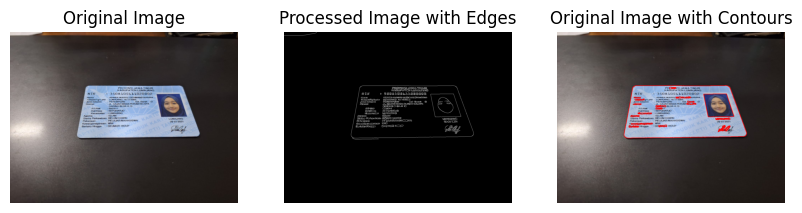

In [ ]:
# Example usage:
image_path = '/content/drive/MyDrive/PCVK/kuis2/dinda-4.jpeg'
processed_image, original_image = preprocess_image(image_path)
contours = find_contours(processed_image, 25)

# Draw the contours on the original image
image_with_contours = original_image.copy()
cv2.drawContours(image_with_contours, contours, -1, (0, 0, 255), 2)

# Display the original and processed images using plt
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

# Original image
axs[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original Image')
axs[0].axis('off')

# Processed image with edges
axs[1].imshow(processed_image, cmap='gray')
axs[1].set_title('Processed Image with Edges')
axs[1].axis('off')

# Original image with contours
axs[2].imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
axs[2].set_title('Original Image with Contours')
axs[2].axis('off')

plt.show()

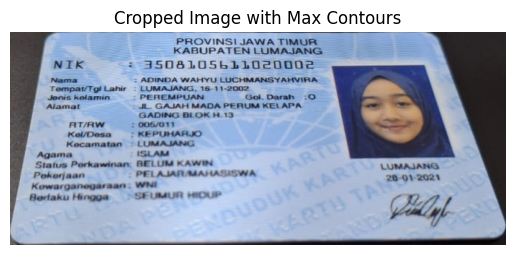

In [ ]:
# Example usage:
cropped_image = crop_image_with_max_contours(original_image, contours)

# Display the cropped image using plt
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
plt.title('Cropped Image with Max Contours')
plt.axis('off')
plt.show()

Screens found : 25
Screen Dimentions [689, 689, 171, 171, 50, 4, 4, 5, 5, 5, 182, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Old Screen Dimentions filtered [171, 171, 50, 4, 4, 5, 5, 5, 182, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Screen Dimentions filtered [689, 689]
Found bill rectagle at  [[1064  565]
 [ 959  302]
 [ 441  301]
 [ 376  580]]
[[ 441.  301.]
 [ 959.  302.]
 [1064.  565.]
 [ 376.  580.]]


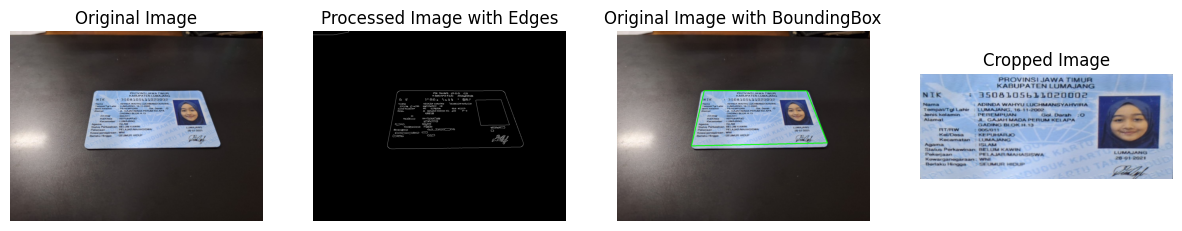

In [ ]:
# Example usage:
image_path = '/content/drive/MyDrive/PCVK/kuis2/dinda-4.jpeg'
# processed_image, original_image = preprocess_image(image_path)
# contours = find_contours(processed_image, 25)

# Draw the contours on the original image
# image_with_contours = original_image.copy()
# cv2.drawContours(image_with_contours, contours, -1, (0, 0, 255), 2)
original_image = cv2.imread(image_path)
cropped_image, imageWithRectangle, edged = convert_object(original_image, isDebug=False)

# Display the original and processed images using plt
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

# Original image
axs[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original Image')
axs[0].axis('off')

# Processed image with edges
axs[1].imshow(edged, cmap='gray')
axs[1].set_title('Processed Image with Edges')
axs[1].axis('off')

# Original Image with BoundingBox
axs[2].imshow(cv2.cvtColor(imageWithRectangle, cv2.COLOR_BGR2RGB))
axs[2].set_title('Original Image with BoundingBox')
axs[2].axis('off')

# Cropped Image
axs[3].imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
axs[3].set_title('Cropped Image')
axs[3].axis('off')

plt.show()

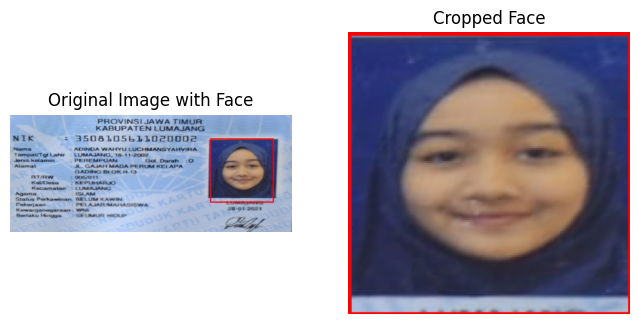

In [ ]:
# Detect and crop faces
result_image, cropped_face = detect_and_crop_faces(cropped_image)

# Display the original image with rectangle drawn around the first detected face and the cropped face
plt.figure(figsize=(8, 4))

# Original image with rectangle drawn around the first detected face
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image with Face')
plt.axis('off')

# Display the cropped face (if a face was detected)
if cropped_face is not None:
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB))
    plt.title('Cropped Face')
    plt.axis('off')

plt.show()

#### 3.1.1 Predict Model Dinda

In [ ]:
# Resize the image to (224-height, 224-width) pixels
image = cv2.resize(cropped_face, (224, 224), interpolation=cv2.INTER_AREA)
# Make the image a numpy array and reshape it to the model's input shape
image = np.asarray(image, dtype=np.float32).reshape(1, 224, 224, 3)

# Normalize the image array
image = (image / 127.5) - 1

image.shape

(1, 224, 224, 3)

In [ ]:
# Predict the model
prediction = model.predict(image)
index = np.argmax(prediction)
class_name = class_names[index]
confidence_score = prediction[0][index]

1/1 [==============================] - 2s 2s/step


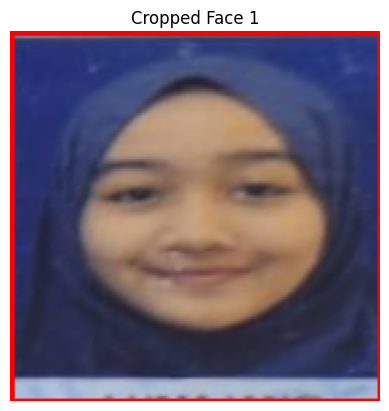


Class: Adinda

Confidence Score: 100 %


In [ ]:
# Display the cropped face using plt
plt.imshow(cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB))
plt.title('Cropped Face 1')
plt.axis('off')
plt.show()

# Print prediction and confidence score
print("\nClass:", class_name[2:])
print("Confidence Score:", str(np.round(confidence_score * 100))[:-2], "%")

#### 3.2.0 Testing Alfan

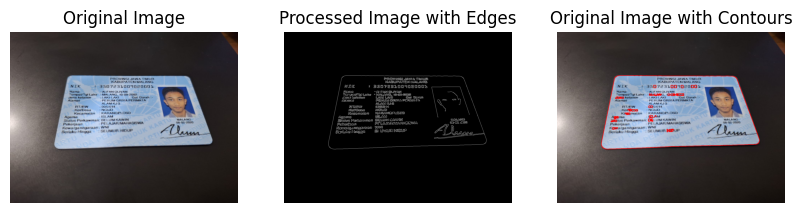

In [ ]:
# Example usage:
image_path = '/content/drive/MyDrive/PCVK/kuis2/alifan-5.jpeg'
processed_image, original_image = preprocess_image(image_path)
contours = find_contours(processed_image, 25)

# Draw the contours on the original image
image_with_contours = original_image.copy()
cv2.drawContours(image_with_contours, contours, -1, (0, 0, 255), 2)

# Display the original and processed images using plt
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

# Original image
axs[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original Image')
axs[0].axis('off')

# Processed image with edges
axs[1].imshow(processed_image, cmap='gray')
axs[1].set_title('Processed Image with Edges')
axs[1].axis('off')

# Original image with contours
axs[2].imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
axs[2].set_title('Original Image with Contours')
axs[2].axis('off')

plt.show()

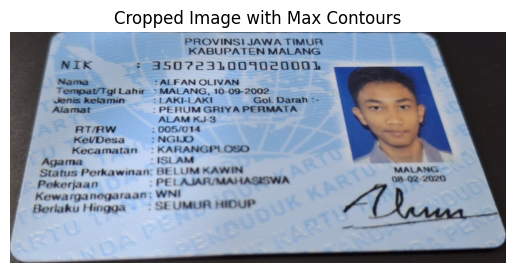

In [ ]:
# Example usage:
cropped_image = crop_image_with_max_contours(original_image, contours)

# Display the cropped image using plt
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
plt.title('Cropped Image with Max Contours')
plt.axis('off')
plt.show()

Screens found : 5
Screen Dimentions [888, 888, 5, 3, 3]
Old Screen Dimentions filtered [5, 3, 3]
Screen Dimentions filtered [888, 888]
Found bill rectagle at  [[ 323  259]
 [ 262  652]
 [1134  618]
 [ 996  250]]
[[ 323.  259.]
 [ 996.  250.]
 [1134.  618.]
 [ 262.  652.]]


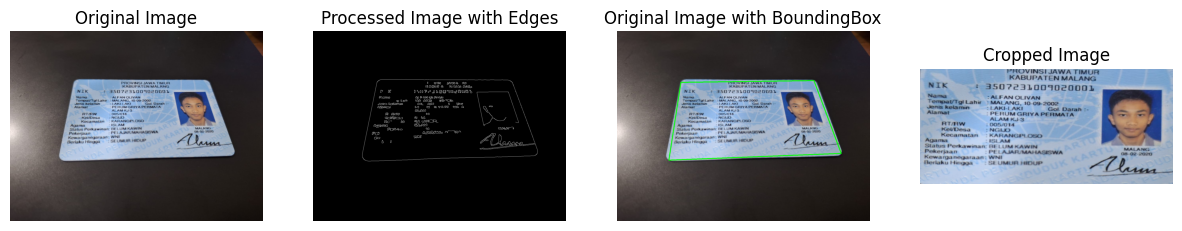

In [ ]:
# Example usage:
image_path = '/content/drive/MyDrive/PCVK/kuis2/alifan-5.jpeg'
# processed_image, original_image = preprocess_image(image_path)
# contours = find_contours(processed_image, 25)

# Draw the contours on the original image
# image_with_contours = original_image.copy()
# cv2.drawContours(image_with_contours, contours, -1, (0, 0, 255), 2)
original_image = cv2.imread(image_path)
cropped_image, imageWithRectangle, edged = convert_object(original_image, isDebug=False)

# Display the original and processed images using plt
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

# Original image
axs[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original Image')
axs[0].axis('off')

# Processed image with edges
axs[1].imshow(edged, cmap='gray')
axs[1].set_title('Processed Image with Edges')
axs[1].axis('off')

# Original Image with BoundingBox
axs[2].imshow(cv2.cvtColor(imageWithRectangle, cv2.COLOR_BGR2RGB))
axs[2].set_title('Original Image with BoundingBox')
axs[2].axis('off')

# Cropped Image
axs[3].imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
axs[3].set_title('Cropped Image')
axs[3].axis('off')

plt.show()

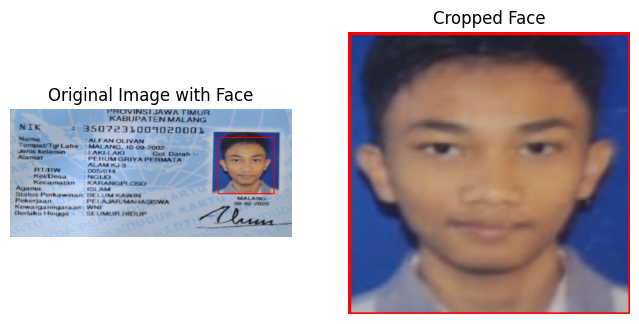

In [ ]:
# Detect and crop faces
result_image, cropped_face = detect_and_crop_faces(cropped_image)

# Display the original image with rectangle drawn around the first detected face and the cropped face
plt.figure(figsize=(8, 4))

# Original image with rectangle drawn around the first detected face
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image with Face')
plt.axis('off')

# Display the cropped face (if a face was detected)
if cropped_face is not None:
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB))
    plt.title('Cropped Face')
    plt.axis('off')

plt.show()

#### 3.2.1 Predict Model Alfan

In [ ]:
# Resize the image to (224-height, 224-width) pixels
image = cv2.resize(cropped_face, (224, 224), interpolation=cv2.INTER_AREA)
# Make the image a numpy array and reshape it to the model's input shape
image = np.asarray(image, dtype=np.float32).reshape(1, 224, 224, 3)

# Normalize the image array
image = (image / 127.5) - 1

image.shape

(1, 224, 224, 3)

In [ ]:
# Predict the model
prediction = model.predict(image)
index = np.argmax(prediction)
class_name = class_names[index]
confidence_score = prediction[0][index]

1/1 [==============================] - 0s 45ms/step


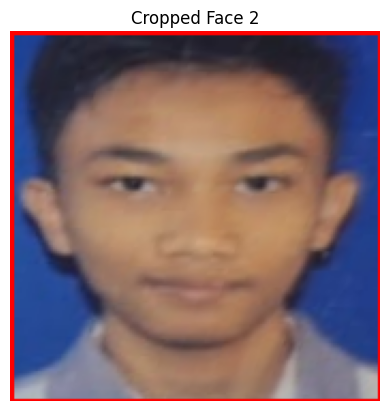


Class: Lukas

Confidence Score: 50 %


In [ ]:
# Display the cropped face using plt
plt.imshow(cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB))
plt.title('Cropped Face 2')
plt.axis('off')
plt.show()

# Print prediction and confidence score
print("\nClass:", class_name[2:])
print("Confidence Score:", str(np.round(confidence_score * 100))[:-2], "%")

#### 3.3.0 Testing Lukas

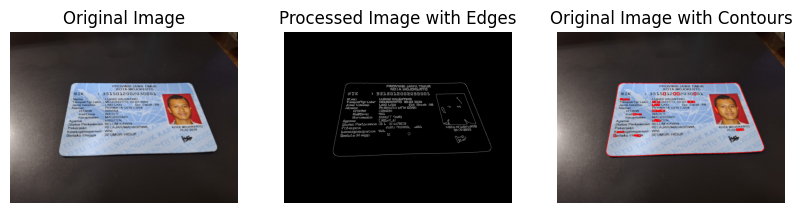

In [ ]:
# Example usage:
image_path = '/content/drive/MyDrive/PCVK/kuis2/lukas-3.jpeg'
processed_image, original_image = preprocess_image(image_path)
contours = find_contours(processed_image, 25)

# Draw the contours on the original image
image_with_contours = original_image.copy()
cv2.drawContours(image_with_contours, contours, -1, (0, 0, 255), 2)

# Display the original and processed images using plt
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

# Original image
axs[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original Image')
axs[0].axis('off')

# Processed image with edges
axs[1].imshow(processed_image, cmap='gray')
axs[1].set_title('Processed Image with Edges')
axs[1].axis('off')

# Original image with contours
axs[2].imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
axs[2].set_title('Original Image with Contours')
axs[2].axis('off')

plt.show()

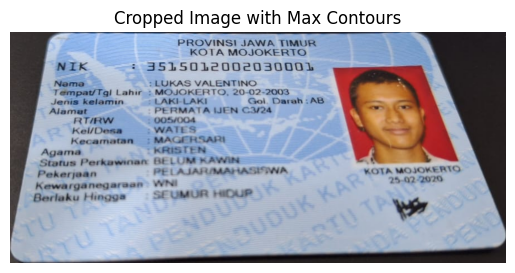

In [ ]:
# Example usage:
cropped_image = crop_image_with_max_contours(original_image, contours)

# Display the cropped image using plt
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
plt.title('Cropped Image with Max Contours')
plt.axis('off')
plt.show()

Screens found : 4
Screen Dimentions [888, 888, 5, 3]
Old Screen Dimentions filtered [5, 3]
Screen Dimentions filtered [888, 888]
Found bill rectagle at  [[1162  640]
 [1013  289]
 [ 372  286]
 [ 275  673]]
[[ 372.  286.]
 [1013.  289.]
 [1162.  640.]
 [ 275.  673.]]


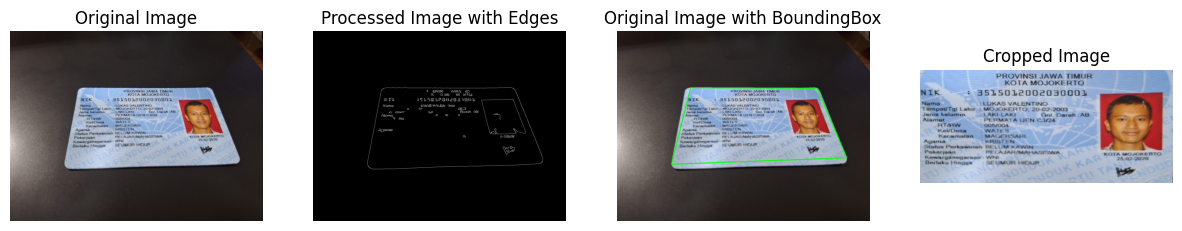

In [ ]:
# Example usage:
image_path = '/content/drive/MyDrive/PCVK/kuis2/lukas-3.jpeg'
# processed_image, original_image = preprocess_image(image_path)
# contours = find_contours(processed_image, 25)

# Draw the contours on the original image
# image_with_contours = original_image.copy()
# cv2.drawContours(image_with_contours, contours, -1, (0, 0, 255), 2)
original_image = cv2.imread(image_path)
cropped_image, imageWithRectangle, edged = convert_object(original_image, isDebug=False)

# Display the original and processed images using plt
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

# Original image
axs[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original Image')
axs[0].axis('off')

# Processed image with edges
axs[1].imshow(edged, cmap='gray')
axs[1].set_title('Processed Image with Edges')
axs[1].axis('off')

# Original Image with BoundingBox
axs[2].imshow(cv2.cvtColor(imageWithRectangle, cv2.COLOR_BGR2RGB))
axs[2].set_title('Original Image with BoundingBox')
axs[2].axis('off')

# Cropped Image
axs[3].imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
axs[3].set_title('Cropped Image')
axs[3].axis('off')

plt.show()

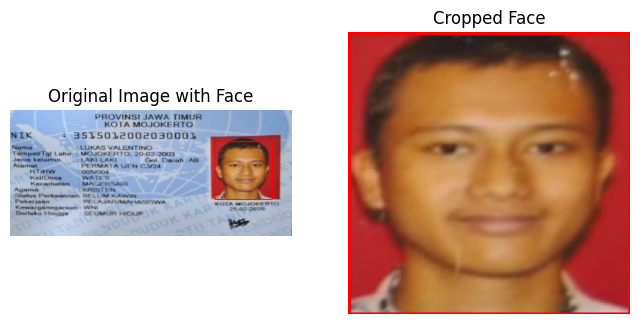

In [ ]:
# Detect and crop faces
result_image, cropped_face = detect_and_crop_faces(cropped_image)

# Display the original image with rectangle drawn around the first detected face and the cropped face
plt.figure(figsize=(8, 4))

# Original image with rectangle drawn around the first detected face
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image with Face')
plt.axis('off')

# Display the cropped face (if a face was detected)
if cropped_face is not None:
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB))
    plt.title('Cropped Face')
    plt.axis('off')

plt.show()

#### 3.3.1 Predict Model Lukas


In [ ]:
# Resize the image to (224-height, 224-width) pixels
image = cv2.resize(cropped_face, (224, 224), interpolation=cv2.INTER_AREA)
# Make the image a numpy array and reshape it to the model's input shape
image = np.asarray(image, dtype=np.float32).reshape(1, 224, 224, 3)

# Normalize the image array
image = (image / 127.5) - 1

image.shape

(1, 224, 224, 3)

In [ ]:
# Predict the model
prediction = model.predict(image)
index = np.argmax(prediction)
class_name = class_names[index]
confidence_score = prediction[0][index]

1/1 [==============================] - 0s 44ms/step


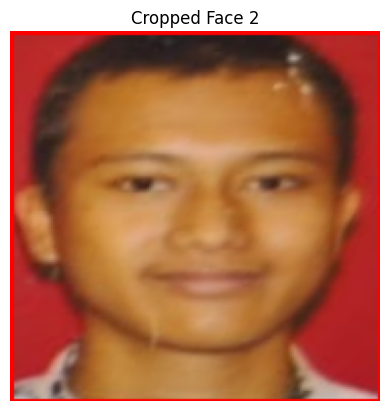


Class: Lukas

Confidence Score: 100 %


In [ ]:
# Display the cropped face using plt
plt.imshow(cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB))
plt.title('Cropped Face 2')
plt.axis('off')
plt.show()

# Print prediction and confidence score
print("\nClass:", class_name[2:])
print("Confidence Score:", str(np.round(confidence_score * 100))[:-2], "%")

#### 3.4.0 Testing Wira

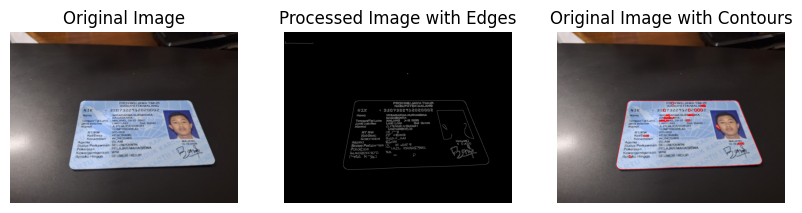

In [ ]:
# Example usage:
image_path = '/content/drive/MyDrive/PCVK/kuis2/wira-11.jpeg'
processed_image, original_image = preprocess_image(image_path)
contours = find_contours(processed_image, 25)

# Draw the contours on the original image
image_with_contours = original_image.copy()
cv2.drawContours(image_with_contours, contours, -1, (0, 0, 255), 2)

# Display the original and processed images using plt
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

# Original image
axs[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original Image')
axs[0].axis('off')

# Processed image with edges
axs[1].imshow(processed_image, cmap='gray')
axs[1].set_title('Processed Image with Edges')
axs[1].axis('off')

# Original image with contours
axs[2].imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
axs[2].set_title('Original Image with Contours')
axs[2].axis('off')

plt.show()

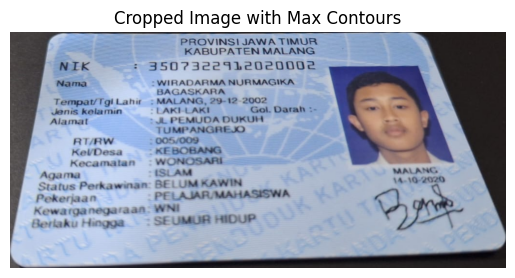

In [ ]:
# Example usage:
cropped_image = crop_image_with_max_contours(original_image, contours)

# Display the cropped image using plt
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
plt.title('Cropped Image with Max Contours')
plt.axis('off')
plt.show()

Screens found : 4
Screen Dimentions [1024, 1024, 5, 3]
Old Screen Dimentions filtered [5, 3]
Screen Dimentions filtered [1024, 1024]
Found bill rectagle at  [[1438  896]
 [1259  483]
 [ 522  481]
 [ 415  934]]
[[ 522.  481.]
 [1259.  483.]
 [1438.  896.]
 [ 415.  934.]]


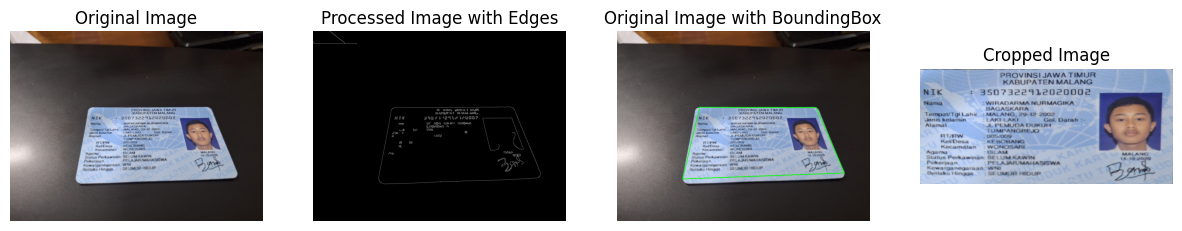

In [ ]:
# Example usage:
image_path = '/content/drive/MyDrive/PCVK/kuis2/wira-11.jpeg'
# processed_image, original_image = preprocess_image(image_path)
# contours = find_contours(processed_image, 25)

# Draw the contours on the original image
# image_with_contours = original_image.copy()
# cv2.drawContours(image_with_contours, contours, -1, (0, 0, 255), 2)
original_image = cv2.imread('/content/drive/MyDrive/PCVK/kuis2/wira-11.jpeg')
cropped_image, imageWithRectangle, edged = convert_object(original_image, isDebug=False)

# Display the original and processed images using plt
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

# Original image
axs[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original Image')
axs[0].axis('off')

# Processed image with edges
axs[1].imshow(edged, cmap='gray')
axs[1].set_title('Processed Image with Edges')
axs[1].axis('off')

# Original Image with BoundingBox
axs[2].imshow(cv2.cvtColor(imageWithRectangle, cv2.COLOR_BGR2RGB))
axs[2].set_title('Original Image with BoundingBox')
axs[2].axis('off')

# Cropped Image
axs[3].imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
axs[3].set_title('Cropped Image')
axs[3].axis('off')

plt.show()

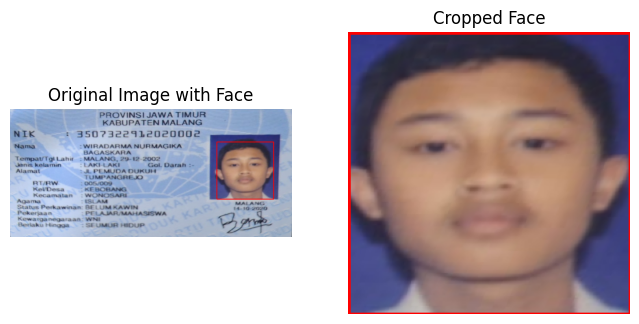

In [ ]:
# Detect and crop faces
result_image, cropped_face = detect_and_crop_faces(cropped_image)

# Display the original image with rectangle drawn around the first detected face and the cropped face
plt.figure(figsize=(8, 4))

# Original image with rectangle drawn around the first detected face
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image with Face')
plt.axis('off')

# Display the cropped face (if a face was detected)
if cropped_face is not None:
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB))
    plt.title('Cropped Face')
    plt.axis('off')

plt.show()

#### 3.4.1 Predict Model Wira


In [ ]:
# Resize the image to (224-height, 224-width) pixels
image = cv2.resize(cropped_face, (224, 224), interpolation=cv2.INTER_AREA)
# Make the image a numpy array and reshape it to the model's input shape
image = np.asarray(image, dtype=np.float32).reshape(1, 224, 224, 3)

# Normalize the image array
image = (image / 127.5) - 1

image.shape

(1, 224, 224, 3)

In [ ]:
# Predict the model
prediction = model.predict(image)
index = np.argmax(prediction)
class_name = class_names[index]
confidence_score = prediction[0][index]

1/1 [==============================] - 0s 49ms/step


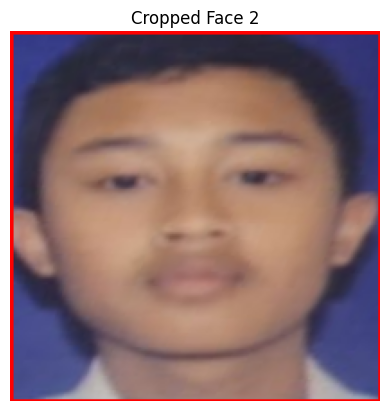


Class: Wira

Confidence Score: 99 %


In [ ]:
# Display the cropped face using plt
plt.imshow(cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB))
plt.title('Cropped Face 2')
plt.axis('off')
plt.show()

# Print prediction and confidence score
print("\nClass:", class_name[2:])
print("Confidence Score:", str(np.round(confidence_score * 100))[:-2], "%")

#### 3.5.0 Testing Driya

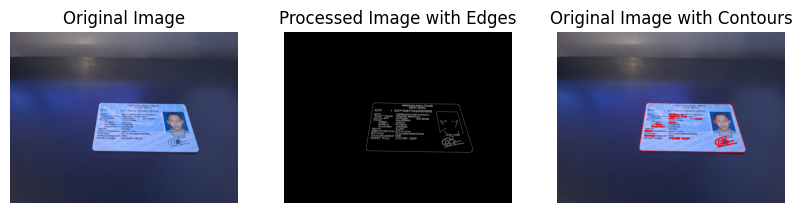

In [ ]:
# Example usage:
image_path = '/content/drive/MyDrive/PCVK/kuis2/driya-2.jpeg'
processed_image, original_image = preprocess_image(image_path)
contours = find_contours(processed_image, 25)

# Draw the contours on the original image
image_with_contours = original_image.copy()
cv2.drawContours(image_with_contours, contours, -1, (0, 0, 255), 2)

# Display the original and processed images using plt
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

# Original image
axs[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original Image')
axs[0].axis('off')

# Processed image with edges
axs[1].imshow(processed_image, cmap='gray')
axs[1].set_title('Processed Image with Edges')
axs[1].axis('off')

# Original image with contours
axs[2].imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
axs[2].set_title('Original Image with Contours')
axs[2].axis('off')

plt.show()

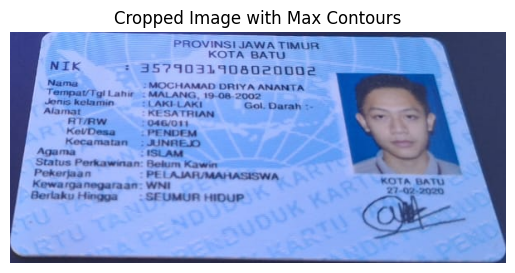

In [ ]:
# Example usage:
cropped_image = crop_image_with_max_contours(original_image, contours)

# Display the cropped image using plt
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
plt.title('Cropped Image with Max Contours')
plt.axis('off')
plt.show()

Screens found : 2
Screen Dimentions [598, 598]
Old Screen Dimentions filtered []
Screen Dimentions filtered [598, 598]
Found bill rectagle at  [[ 500  406]
 [ 472  666]
 [1058  666]
 [ 974  406]]
[[ 500.  406.]
 [ 974.  406.]
 [1058.  666.]
 [ 472.  666.]]


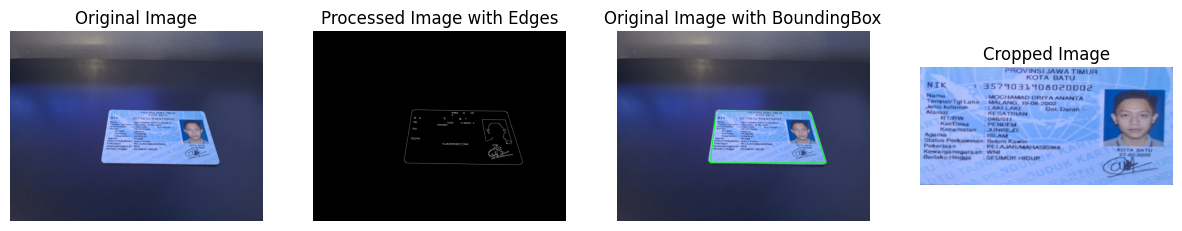

In [ ]:
# Example usage:
image_path = '/content/drive/MyDrive/PCVK/kuis2/driya-2.jpeg'
# processed_image, original_image = preprocess_image(image_path)
# contours = find_contours(processed_image, 25)

# Draw the contours on the original image
# image_with_contours = original_image.copy()
# cv2.drawContours(image_with_contours, contours, -1, (0, 0, 255), 2)
original_image = cv2.imread(image_path)
cropped_image, imageWithRectangle, edged = convert_object(original_image, isDebug=False)

# Display the original and processed images using plt
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

# Original image
axs[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original Image')
axs[0].axis('off')

# Processed image with edges
axs[1].imshow(edged, cmap='gray')
axs[1].set_title('Processed Image with Edges')
axs[1].axis('off')

# Original Image with BoundingBox
axs[2].imshow(cv2.cvtColor(imageWithRectangle, cv2.COLOR_BGR2RGB))
axs[2].set_title('Original Image with BoundingBox')
axs[2].axis('off')

# Cropped Image
axs[3].imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
axs[3].set_title('Cropped Image')
axs[3].axis('off')

plt.show()

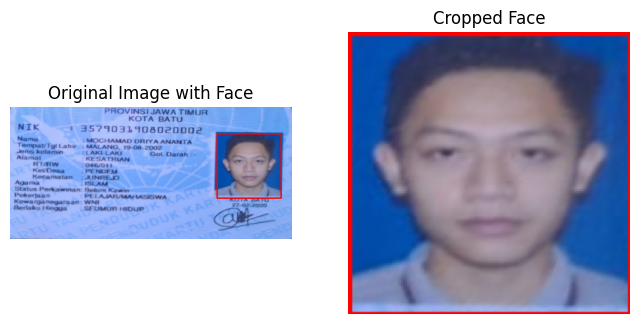

In [ ]:
# Detect and crop faces
result_image, cropped_face = detect_and_crop_faces(cropped_image)

# Display the original image with rectangle drawn around the first detected face and the cropped face
plt.figure(figsize=(8, 4))

# Original image with rectangle drawn around the first detected face
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image with Face')
plt.axis('off')

# Display the cropped face (if a face was detected)
if cropped_face is not None:
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB))
    plt.title('Cropped Face')
    plt.axis('off')

plt.show()

#### 3.5.1 Predict Model Driya


In [ ]:
# Resize the image to (224-height, 224-width) pixels
image = cv2.resize(cropped_face, (224, 224), interpolation=cv2.INTER_AREA)
# Make the image a numpy array and reshape it to the model's input shape
image = np.asarray(image, dtype=np.float32).reshape(1, 224, 224, 3)

# Normalize the image array
image = (image / 127.5) - 1

image.shape

(1, 224, 224, 3)

In [ ]:
# Predict the model
prediction = model.predict(image)
index = np.argmax(prediction)
class_name = class_names[index]
confidence_score = prediction[0][index]

1/1 [==============================] - 0s 45ms/step


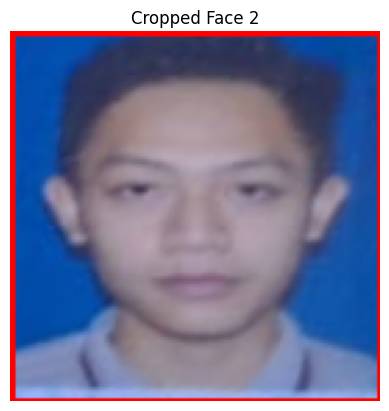


Class: Alfan Olivan

Confidence Score: 34 %


In [ ]:
# Display the cropped face using plt
plt.imshow(cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB))
plt.title('Cropped Face 2')
plt.axis('off')
plt.show()

# Print prediction and confidence score
print("\nClass:", class_name[2:])
print("Confidence Score:", str(np.round(confidence_score * 100))[:-2], "%")